## Klasa OFCandle

In [1]:
import sys
sys.path.append('../pyorderedfuzzy')

In [2]:
import numpy as np
import pandas as pd
from ofcandle import OFCandle
import ofnumber as ofn
import ofmodels as ofm
%matplotlib widget
import matplotlib.pyplot as plt

__Wczytanied danych__

In [3]:
df = pd.read_csv(r'../data/WIG20.prn')

In [4]:
df.head()

,Name,Date,Time,Open,High,Low,Close,Volume,Oi
0,WIG20,20001117,1002,1614.0,1614.0,1614.0,1614.0,0,0
1,WIG20,20001117,1003,1615.0,1615.0,1615.0,1615.0,0,0
2,WIG20,20001117,1004,1615.0,1616.0,1615.0,1616.0,0,0
3,WIG20,20001117,1005,1615.0,1615.0,1615.0,1615.0,0,0
4,WIG20,20001117,1006,1614.0,1615.0,1614.0,1615.0,0,0


In [5]:
df['Date'] = df['Date'].astype(str).apply(lambda x: pd.datetime(int(x[:4]), int(x[4:6]), int(x[6:])))

In [6]:
df = df[['Date', 'Time', 'Close']]
df.sort_values(by=['Date', 'Time'])
df.head()

,Date,Time,Close
0,2000-11-17,1002,1614.0
1,2000-11-17,1003,1615.0
2,2000-11-17,1004,1616.0
3,2000-11-17,1005,1615.0
4,2000-11-17,1006,1615.0


In [7]:
df_day = df.groupby('Date')

In [8]:
def to_ofc(s):
    x = s.values
    ctype = 'empirical'
    data = {'price': x, 'volume': np.zeros_like(x), 'spread': np.zeros_like(x)}
    params = {'wtype': 'clear', 'param_s': 'average', 'param_c': 'none', 'dim': 11, 'order': None}
    return OFCandle(ctype, data, params)

In [9]:
df_agg = df_day.agg({'Close': [to_ofc, 'last']})
df_agg.head()

Close        
                                                       to_ofc    last
Date                                                                 
2000-11-17  ([1614.         1620.         1624.         16...  1643.0
2000-11-20  ([1646.        1648.        1650.        1652....  1653.0
2000-11-21  ([1650.         1651.         1652.         16...  1660.0
2000-11-22  ([1642.         1640.         1639.         16...  1639.0
2000-11-23  ([1645.         1635.         1632.         16...  1626.0

In [10]:
ofts = ofm.OFSeries(df_agg[('Close', 'to_ofc')].values)

In [11]:
close = df_agg[('Close', 'last')].values

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
ofts.plot_ofseries(ax, s=4000, e=4577)
ax.plot(close[4000:4577])
plt.show()

A Jupyter Widget

In [13]:
ofts_logret = ofts.transform(method='logret')
logret = np.log(close[1:]/close[:-1])

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
ofts_logret.plot_ofseries(ax, s=3999, e=4576)
ax.plot(logret[3999:4576])
plt.show()

A Jupyter Widget

In [15]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(logret[3999:4576], bins=40)
plt.show()

A Jupyter Widget

In [16]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
axf = fig.add_subplot(121, projection='3d')
axg = fig.add_subplot(122, projection='3d')
ofts_logret.plot_3d_histogram(axf, axg)
plt.show()

A Jupyter Widget

Klasyczny GARCH

In [17]:
from arch import arch_model
garch = arch_model(pd.Series(logret[3999:4576]*100), mean='constant', p=1, q=1).fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 852.5104420501684
Iteration:      2,   Func. Count:     16,   Neg. LLF: 852.4718855868891
Iteration:      3,   Func. Count:     25,   Neg. LLF: 852.237760266993
Iteration:      4,   Func. Count:     34,   Neg. LLF: 852.2371852712433
Iteration:      5,   Func. Count:     41,   Neg. LLF: 852.2269061380836
Iteration:      6,   Func. Count:     48,   Neg. LLF: 852.2176702481736
Iteration:      7,   Func. Count:     54,   Neg. LLF: 852.2164997330856
Iteration:      8,   Func. Count:     60,   Neg. LLF: 852.2164762132034
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 852.2164755431113
            Iterations: 8
            Function evaluations: 61
            Gradient evaluations: 8


In [18]:
garch.params

mu          0.049192
omega       0.019364
alpha[1]    0.015655
beta[1]     0.966774
Name: params, dtype: float64

In [19]:
fig, ax = plt.subplots(figsize=(4, 4))
garch.resid.hist(bins=20)
plt.show()

A Jupyter Widget

In [20]:
garch.resid.mean(), garch.resid.var()

(-0.0010089172727799343, 1.134339780283509)

In [21]:
forecast = garch.forecast(horizon=5, align='origin')

In [22]:
forecast.mean.values[-1]

array([0.04919245, 0.04919245, 0.04919245, 0.04919245, 0.04919245])

In [23]:
forecast.variance.values[-1]

array([0.98054065, 0.98267584, 0.98477351, 0.98683433, 0.98885893])

In [24]:
ofgarch = ofm.OFGARCH(tmean='constant')

In [25]:
ofgarch.fit(ofm.OFSeries([ofn.OFNumber.init_from_scalar(x*100, dim=11) for x in logret[3999:4576]]))

In [26]:
ofgarch.coefs.values

array([([0.04919245 0.04919245 0.04919245 0.04919245 0.04919245 0.04919245
 0.04919245 0.04919245 0.04919245 0.04919245 0.04919245], [0.04919245 0.04919245 0.04919245 0.04919245 0.04919245 0.04919245
 0.04919245 0.04919245 0.04919245 0.04919245 0.04919245]),
       ([0.01936432 0.01936432 0.01936432 0.01936432 0.01936432 0.01936432
 0.01936432 0.01936432 0.01936432 0.01936432 0.01936432], [0.01936432 0.01936432 0.01936432 0.01936432 0.01936432 0.01936432
 0.01936432 0.01936432 0.01936432 0.01936432 0.01936432]),
       ([0.01565526 0.01565526 0.01565526 0.01565526 0.01565526 0.01565526
 0.01565526 0.01565526 0.01565526 0.01565526 0.01565526], [0.01565526 0.01565526 0.01565526 0.01565526 0.01565526 0.01565526
 0.01565526 0.01565526 0.01565526 0.01565526 0.01565526]),
       ([0.96677369 0.96677369 0.96677369 0.96677369 0.96677369 0.96677369
 0.96677369 0.96677369 0.96677369 0.96677369 0.96677369], [0.96677369 0.96677369 0.96677369 0.96677369 0.96677369 0.96677369
 0.96677369 0.96677369 

In [32]:
offorecasts = ofgarch.predict(5, error=True)

In [34]:
offorecasts[0].values[0], offorecasts[1].values[0], offorecasts[2].values[0], offorecasts[3].values[0]

(([0.04919245 0.04919245 0.04919245 0.04919245 0.04919245 0.04919245
  0.04919245 0.04919245 0.04919245 0.04919245 0.04919245], [0.04919245 0.04919245 0.04919245 0.04919245 0.04919245 0.04919245
  0.04919245 0.04919245 0.04919245 0.04919245 0.04919245]),
 ([0.98054065 0.98054065 0.98054065 0.98054065 0.98054065 0.98054065
  0.98054065 0.98054065 0.98054065 0.98054065 0.98054065], [0.98054065 0.98054065 0.98054065 0.98054065 0.98054065 0.98054065
  0.98054065 0.98054065 0.98054065 0.98054065 0.98054065]),
 ([1.6006325 1.6006325 1.6006325 1.6006325 1.6006325 1.6006325 1.6006325
  1.6006325 1.6006325 1.6006325 1.6006325], [1.6006325 1.6006325 1.6006325 1.6006325 1.6006325 1.6006325 1.6006325
  1.6006325 1.6006325 1.6006325 1.6006325]),
 ([1.56675899 1.56675899 1.56675899 1.56675899 1.56675899 1.56675899
  1.56675899 1.56675899 1.56675899 1.56675899 1.56675899], [1.56675899 1.56675899 1.56675899 1.56675899 1.56675899 1.56675899
  1.56675899 1.56675899 1.56675899 1.56675899 1.56675899]))

In [35]:
(0.98054065**0.5)*1.56675899+0.04919245

1.6006324939216183

In [30]:
ofn.fpower(offorecasts[1].values[0], 0.5) + offorecasts[0].values[0]

([1.03941498 1.03941498 1.03941498 1.03941498 1.03941498 1.03941498
 1.03941498 1.03941498 1.03941498 1.03941498 1.03941498], [1.03941498 1.03941498 1.03941498 1.03941498 1.03941498 1.03941498
 1.03941498 1.03941498 1.03941498 1.03941498 1.03941498])

In [37]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
axf = fig.add_subplot(121, projection='3d')
axg = fig.add_subplot(122, projection='3d')
ofgarch.residuals.plot_3d_histogram(axf, axg)
plt.show()

A Jupyter Widget

In [23]:
ofgarch = ofm.OFGARCH(tmean='constant')
ofgarch.fit(ofm.OFSeries(ofts_logret[3999:4576]*100))

In [24]:
fig, ax = plt.subplots()
ofgarch.coefs.plot_ofseries(ax)
plt.show()

A Jupyter Widget

In [25]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
axf = fig.add_subplot(121, projection='3d')
axg = fig.add_subplot(122, projection='3d')
ofgarch.residuals.plot_3d_histogram(axf, axg)
plt.show()

A Jupyter Widget

In [26]:
ofgarch.residuals.order_probability()

0.5043327556325823

In [27]:
ofgarch.residuals.mean_crisp()

-0.0025280313668469344

In [28]:
ofgarch.residuals.mean_fuzzy()

([-5.41238964e-04 -1.27229321e-04  2.08824331e-06  2.28613420e-04
  3.37238989e-04  3.16819808e-04  9.08171575e-05 -2.08106821e-04
 -1.22344196e-03 -1.73638924e-03 -2.58230950e-03], [-0.0047359  -0.00337109 -0.00384247 -0.00479481 -0.00535434 -0.00607212
 -0.00679577 -0.00544349 -0.00393079 -0.00341529 -0.00258231])

In [29]:
ofgarch.residuals.var_fuzzy()

([1.75306144 1.27046039 1.11850956 1.02692058 0.95203067 0.89926136
 0.85831241 0.83066025 0.80622557 0.79214796 0.78284408], [1.73334343 1.36286953 1.20965733 1.09635584 1.00908611 0.95254644
 0.89710289 0.85744716 0.8201364  0.79732717 0.78284408])

In [30]:
import ofrandom as ofr

In [31]:
ofr.ofnormal_mu_est(ofgarch.residuals)

([-0.80455545 -0.60767935 -0.51501846 -0.43767389 -0.36732912 -0.30557454
 -0.24792688 -0.19120778 -0.13673664 -0.07709793 -0.00258231], [ 0.79927831  0.60418103  0.51117808  0.43310769  0.36231202  0.29981924
  0.24122194  0.18555618  0.13158241  0.07194625 -0.00258231])

In [32]:
ofr.ofnormal_sig2_est(ofgarch.residuals)

([0.367719   0.2060944  0.16192479 0.13455307 0.1063449  0.09583883
 0.08320824 0.07363369 0.05763062 0.04881538 0.03441018], [0.33345262 0.19479537 0.1419279  0.1120797  0.09127008 0.07555266
 0.05552202 0.04652088 0.03580717 0.03266699 0.03441018])

In [33]:
ofr.ofnormal_s2_est(ofgarch.residuals)

0.748433902338783

In [34]:
ofr.ofnormal_p_est(ofgarch.residuals)

0.5043327556325823

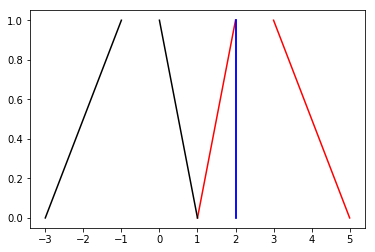

In [23]:
c = 2 - a
b = OFNumber.init_from_scalar(2, dim=6)
fig, ax = plt.subplots()
a.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'r'}, kwargs_g={'c': 'r'})
b.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'b'}, kwargs_g={'c': 'b'})
c.plot_ofn(ax, plot_as='classic')
plt.show()

- mnożenie

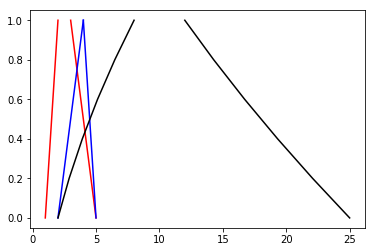

In [24]:
a = OFNumber.init_trapezoid_x0x1(1, 2, 5, 3, dim=6)
b = OFNumber.init_trapezoid_x0x1(2, 4, 5, 4, dim=6)
c = a * b
fig, ax = plt.subplots()
a.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'r'}, kwargs_g={'c': 'r'})
b.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'b'}, kwargs_g={'c': 'b'})
c.plot_ofn(ax, plot_as='classic')
plt.show()

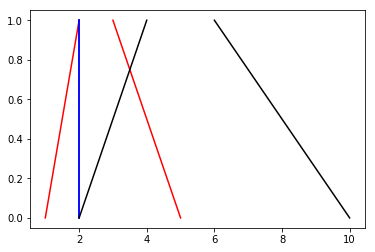

In [25]:
c = a * 2
b = OFNumber.init_from_scalar(2, dim=6)
fig, ax = plt.subplots()
a.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'r'}, kwargs_g={'c': 'r'})
b.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'b'}, kwargs_g={'c': 'b'})
c.plot_ofn(ax, plot_as='classic')
plt.show()

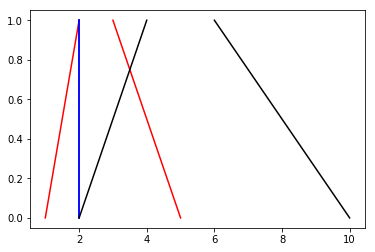

In [26]:
c = 2 * a
b = OFNumber.init_from_scalar(2, dim=6)
fig, ax = plt.subplots()
a.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'r'}, kwargs_g={'c': 'r'})
b.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'b'}, kwargs_g={'c': 'b'})
c.plot_ofn(ax, plot_as='classic')
plt.show()

- dzielenie

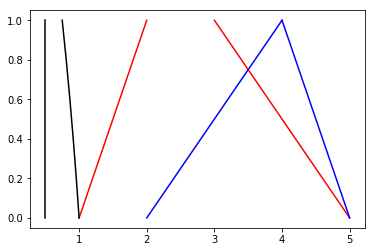

In [27]:
a = OFNumber.init_trapezoid_x0x1(1, 2, 5, 3, dim=6)
b = OFNumber.init_trapezoid_x0x1(2, 4, 5, 4, dim=6)
c = a / b
fig, ax = plt.subplots()
a.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'r'}, kwargs_g={'c': 'r'})
b.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'b'}, kwargs_g={'c': 'b'})
c.plot_ofn(ax, plot_as='classic')
plt.show()

In [28]:
d = OFNumber.init_trapezoid_x0x1(-1, 4, 5, 4, dim=6)
c = a/d
c

ZeroDivisionError: division by zero

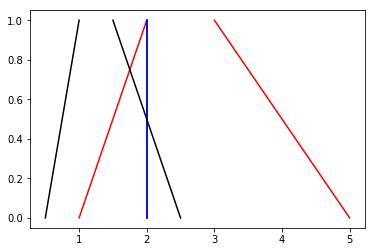

In [29]:
c = a / 2
b = OFNumber.init_from_scalar(2, dim=6)
fig, ax = plt.subplots()
a.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'r'}, kwargs_g={'c': 'r'})
b.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'b'}, kwargs_g={'c': 'b'})
c.plot_ofn(ax, plot_as='classic')
plt.show()

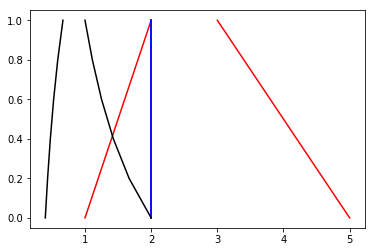

In [30]:
c = 2 / a
b = OFNumber.init_from_scalar(2, dim=6)
fig, ax = plt.subplots()
a.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'r'}, kwargs_g={'c': 'r'})
b.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'b'}, kwargs_g={'c': 'b'})
c.plot_ofn(ax, plot_as='classic')
plt.show()

In [31]:
c = a/0
c

ZeroDivisionError: division by zero

- element przeciwny

In [32]:
c = -a
c

([-1.  -1.2 -1.4 -1.6 -1.8 -2. ], [-5.  -4.6 -4.2 -3.8 -3.4 -3. ])

__Porównania:__

In [33]:
a = OFNumber.init_trapezoid_x0x1(-1, 2, 5, 3, dim=6)
b = OFNumber.init_trapezoid_x0x1(2, 4, 5, 4, dim=6)

In [34]:
a == b

False

In [35]:
a == 2

False

In [36]:
a != b

True

In [37]:
2 != b

True

In [38]:
a < b

False

In [39]:
a < 2

False

In [40]:
a <= b

False

In [41]:
a <= 10

True

In [42]:
a > b

False

In [43]:
a > -2

True

In [44]:
a >= b

False

In [45]:
a >= 0

False

__Wartość funkcji w dowolnym punkcie z przedziału [0, 1]:__

In [46]:
a = OFNumber.init_trapezoid_x0x1(-1, 2, 5, 3, dim=6)
a

([-1.  -0.4  0.2  0.8  1.4  2. ], [5.  4.6 4.2 3.8 3.4 3. ])

In [47]:
a(0.15)

(array(-0.55), array(4.7))

In [48]:
x = np.array([0.2, 0.44])
a(x)

(array([-0.4 ,  0.32]), array([4.6 , 4.12]))

__Alpha przekrój, nośnik, jądro:__

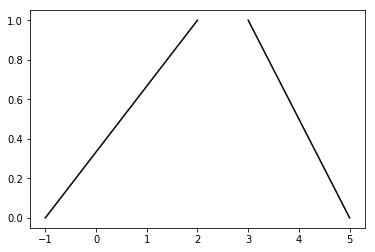

In [49]:
a = OFNumber.init_trapezoid_x0x1(-1, 2, 5, 3, dim=6)
fig, ax = plt.subplots()
a.plot_ofn(ax, plot_as='classic')
plt.show()

In [50]:
a.acut(0.52)

((0.56, 2.0), (3.0, 3.96))

In [51]:
a.ker()

((2.0, 2.0), (3.0, 3.0))

In [52]:
a.supp()

((-1.0, 2.0), (3.0, 5.0))

__Wyostrzanie:__

In [53]:
a = OFNumber.init_trapezoid_x0x1(-1, 2, 5, 3, dim=6)

In [54]:
a.defuzzy(method='expected')

2.25

In [55]:
a.defuzzy(method='scog')

2.1857142857142855

__Funkcje matematyczne:__

In [56]:
from ofnumber import fexp, fabs, flog, fpower, fmax, fmin
a = OFNumber.init_trapezoid_x0x1(-1, 2, 5, 3, dim=6)

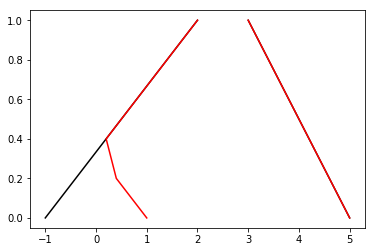

In [57]:
b = fabs(a)
fig, ax = plt.subplots()
a.plot_ofn(ax, plot_as='classic')
b.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'r'}, kwargs_g={'c': 'r'})
plt.show()

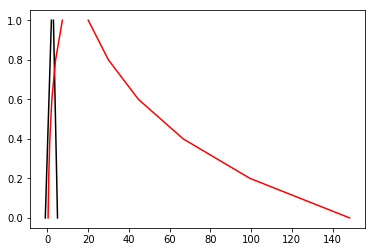

In [58]:
b = fexp(a)
fig, ax = plt.subplots()
a.plot_ofn(ax, plot_as='classic')
b.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'r'}, kwargs_g={'c': 'r'})
plt.show()

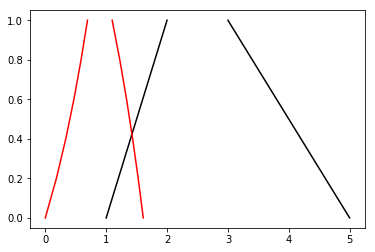

In [59]:
a = OFNumber.init_trapezoid_x0x1(1, 2, 5, 3, dim=6)
b = flog(a)
fig, ax = plt.subplots()
a.plot_ofn(ax, plot_as='classic')
b.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'r'}, kwargs_g={'c': 'r'})
plt.show()

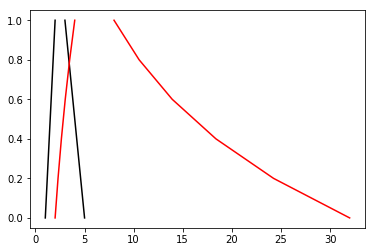

In [60]:
a = OFNumber.init_trapezoid_x0x1(1, 2, 5, 3, dim=6)
b = fpower(2, a)
fig, ax = plt.subplots()
a.plot_ofn(ax, plot_as='classic')
b.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'r'}, kwargs_g={'c': 'r'})
plt.show()

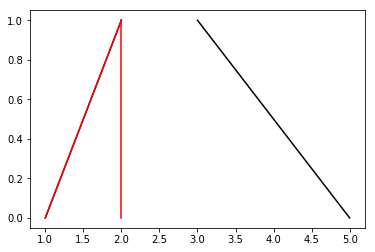

In [61]:
a = OFNumber.init_trapezoid_x0x1(1, 2, 5, 3, dim=6)
b = fmin(a, 2)
fig, ax = plt.subplots()
a.plot_ofn(ax, plot_as='classic')
b.plot_ofn(ax, plot_as='classic', kwargs_f={'c': 'r'}, kwargs_g={'c': 'r'})
plt.show()